In [95]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
import scipy
from numpy.polynomial.chebyshev import chebval
from scipy.linalg import fractional_matrix_power

In [96]:
def generate_hermitian_matrix(M, choice=None):
    if choice == "random":
        """Generates an M x M random Hermitian matrix taking values from a normal distribution."""
        H = np.random.randn(M, M) + 1j * np.random.randn(M, M)
        H = 0.5 * (H + H.conj().T)  # Ensure Hermitian

        return H
    
    elif choice == "synthetic":
        """Generates a synthetic Hermitian matrix."""
        i, j = np.meshgrid(np.arange(M), np.arange(M), indexing="ij")
        H = np.exp(-0.5 * np.abs(i - j)) * np.sin(i + j)
        # H[np.abs(H) < 1e-5] = 0  # Set small values to zero
        return H
    else:
        raise ValueError("Invalid choice. Use 'random' or 'synthetic'.")

In [97]:
def normalize(H, choice, eigenvalsh=None):
    
    if choice == 'none':
        return H
    
    elif choice == 'normal':
        # Normalize the matrix
        norm = np.max(np.abs(eigenvalsh))
        return H / norm
    
    elif choice == 'norm01':
        a = np.min(eigenvalsh) - 1e-6
        b = np.max(eigenvalsh) + 1e-6
        H_normalized = (H - a * np.eye(H.shape[0])) / (b - a)
        return H_normalized
    
    else:
        raise ValueError("Invalid normalization choice. Use 'none', 'normal', or 'norm01'.")

In [98]:
def qrte_cond(H, N, psi_0, eigenvalsh):

    H_norm = normalize(H,choice='normal',eigenvalsh=eigenvalsh)
    deltaE_L = np.abs(eigenvalsh[N-1] - eigenvalsh[0]) / np.max(np.abs(eigenvalsh))
    deltat = np.pi/deltaE_L
    exp_H = expm(-1j * deltat * H_norm)

    Psi_0 = np.empty((H.shape[0],N), dtype=complex)
    v = psi_0.copy()
    v /= np.linalg.norm(v)
    for i in range(N):
        Psi_0[:, i] = v.flatten()
        v = exp_H @ v
        v /= np.linalg.norm(v)

    cond = np.linalg.cond(Psi_0)
    print(f"Condition number for QRTE basis for N={N}: {cond}")
    return cond

In [99]:
def chebyshev_cond(H, N, psi_0, eigenvalsh):

    H_norm = normalize(H, choice='normal', eigenvalsh=eigenvalsh)
    
    Psi_0 = np.empty((H.shape[0], N), dtype=complex)
    T_prev = np.eye(H.shape[0], dtype=complex)
    T_curr = H_norm.copy()
    Psi_0[:, 0] = psi_0.flatten()
    Psi_0[:, 1] = (T_curr @ psi_0).flatten()
    for i in range(2, N):
        T_next = 2 * H_norm @ T_curr - T_prev
        T_prev, T_curr = T_curr, T_next
        Psi_0[:, i] = (T_curr @ psi_0).flatten()

    Psi_0 /= np.linalg.norm(Psi_0, axis=0, keepdims=True)

    cond = np.linalg.cond(Psi_0)
    print(f"Condition number for Chebsyhev basis for N={N}: {cond}")
    return cond

In [100]:
M =  1024 # Dimension of the matrix
H = generate_hermitian_matrix(M, choice='random')

psi_0 = np.random.randn(M, 1) + 1j*np.random.randn(M, 1)
psi_0 /= np.linalg.norm(psi_0, axis=0, keepdims=True)

eigenvalsh = np.linalg.eigvalsh(H)

print("Matrix size: ", M)

Matrix size:  1024


In [101]:
cond_qrte = []
cond_chebyshev = []
for N in [10,100,200,300,400,500]:
    cond_qrte.append(qrte_cond(H,N,psi_0, eigenvalsh))
    cond_chebyshev.append(chebyshev_cond(H,N,psi_0, eigenvalsh))

Condition number for QRTE basis for N=10: 1.2023657892937358
Condition number for Chebsyhev basis for N=10: 6.311288178498798
Condition number for QRTE basis for N=100: 2.247596811224339
Condition number for Chebsyhev basis for N=100: 1967279.5703177955
Condition number for QRTE basis for N=200: 3.275493906357442
Condition number for Chebsyhev basis for N=200: 2689944969882973.0
Condition number for QRTE basis for N=300: 5.97698247066441
Condition number for Chebsyhev basis for N=300: 5428429949082155.0
Condition number for QRTE basis for N=400: 6.237700787357873
Condition number for Chebsyhev basis for N=400: 9041832256947540.0
Condition number for QRTE basis for N=500: 45.896982814208826
Condition number for Chebsyhev basis for N=500: 1.551712418887279e+16


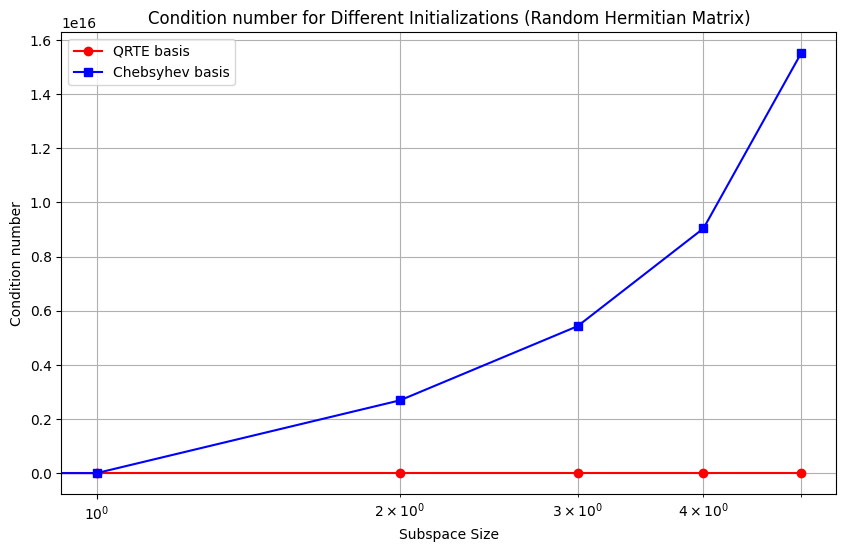

In [103]:
plt.figure(figsize=(10,6))
plt.title('Condition number for Different Initializations (Random Hermitian Matrix)')
plt.plot(np.arange(len(cond_qrte)),cond_qrte,marker='o', label='QRTE basis', color='red')
plt.plot(np.arange(len(cond_chebyshev)),cond_chebyshev, marker='s',label='Chebsyhev basis', color='blue')
plt.xscale('log')
plt.grid(True, 'both','both')
plt.legend()
plt.xlabel('Subspace Size')
plt.ylabel('Condition number')
plt.show()